# Spectral Normalization

Created by Sharon Xuesong Wang of THU ObsAstro, 2022.4.26

## Objective

Extract a 1-D spectrum from a 2-D image of a long-slit spectrum, determine wavelength solution, and then measure the redshift of the target.


## Key steps
- Define target and background apertures
- Subtract the background contribution from the target aperture
- Extract (sum) the counts in the background subtracted target aperture
- Load in the wavelength solution
- Plot the extracted 1-D spectrum


## Required dependencies

Please check that you can import the following python packages without any problem. If anyone is missing (likely specutils), please use `pip install <module>` in your terminal **or** the code block below to install it.

* python 3
* astropy
* numpy
* scipy
* matplotlib
* specutils

In [183]:
# Install the missing python package - You need internet to do this!
import sys
!{sys.executable} -m pip install specutils

# Try Conda if pip doesn't work
# !conda install --yes --prefix {sys.prefix} specutils

In [184]:
# python modules that we will use
import os
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import specutils

%matplotlib inline
import matplotlib.pylab as plt

In [185]:
# change plotting defaults
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')
plt.rcParams['figure.figsize'] = (17, 7)

## Read in the solar spectrum

In [186]:
# load the wavelength calibrated spectrum
from astropy.io import ascii

spec_data = ascii.read('sun_wavs_spec.csv')
wavs = spec_data['col1']
spec = spec_data['col2']
norm_spec = spec_data['col3']  # this is the continuum normalized spectrum, i.e., the right answer! 
                               # We don't need this just yet

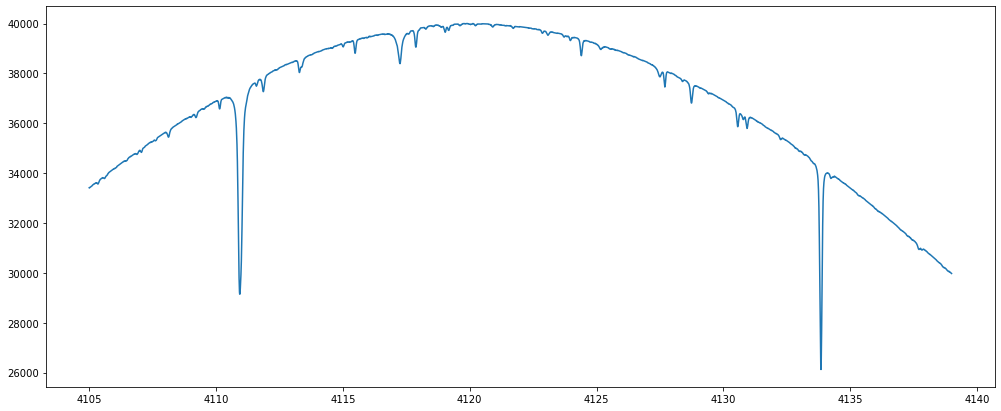

In [187]:
# plot the spectrum here
plt.plot(wavs, spec)

## Do a quick continuum fit

In [188]:
# now let's try to remove the continuum
# First, we need some functions from the specutils package
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from astropy import units as u

In [189]:
# This package needs to define a Spectrum1D object, which must have units
# The unit for the flux is counts, and it's angstrom for the wavelength.
spectrum = Spectrum1D(flux=spec*u.ct, spectral_axis=wavs*u.angstrom)

In [190]:
# Let's use the fit continuum function to do a quick fit
g1_fit = fit_generic_continuum(spectrum)
cont_fitted = g1_fit(wavs*u.angstrom)

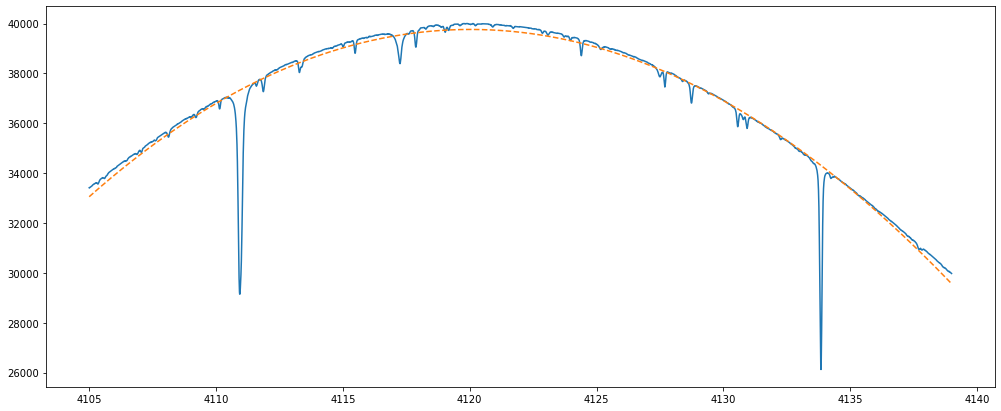

In [191]:
# plot your spectrum and the fitted continuum in dash lines here
plt.plot(wavs, spec)  # original spectrum
plt.plot(wavs, cont_fitted,'--')  # the continuum you are fitting

## Improve the fit by tweeking some parameters

There are 2 key parameters we can change in fitting the continuum:

* median_window\
The width for the window to apply a median filter to the spectrum, the default is only 3.

* model\
The model we would like to use to fit the continuum shape, we use the Chebyshev polynomials, which are quite flexible. The default is a 3rd order Chebyshev polynomial. You can change this to a higher order one.

In [192]:
from astropy.modeling.models import Chebyshev1D

# The parameters are at their default values now. Change them to see if you can get a better fit.
g1_fit = fit_generic_continuum(spectrum, median_window=5, model=Chebyshev1D(4))
cont_fitted = g1_fit(wavs*u.angstrom)

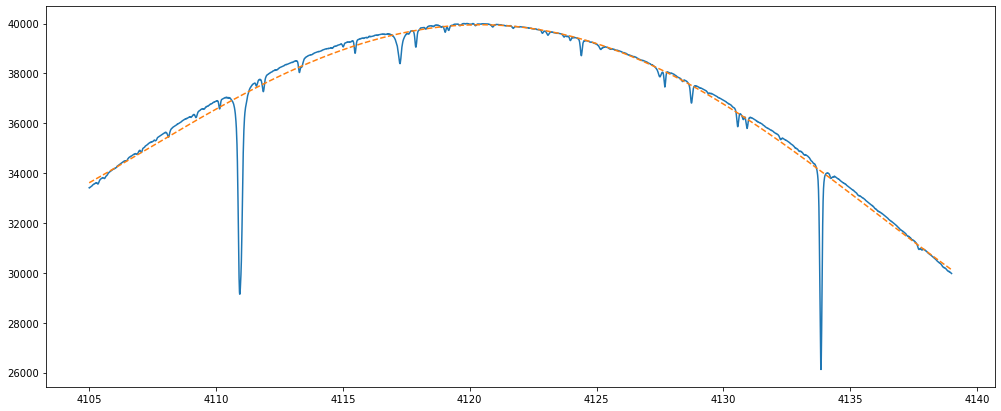

In [193]:
# plot your fit here to check it
plt.plot(wavs, spec)
plt.plot(wavs, cont_fitted,'--')

## Exclude prominent lines for a better continuum fit

In [194]:
# Let's do a better one by defining good spectral regions free of strong lines.
# This requires another function, fit_continuum
from specutils.fitting.continuum import fit_continuum

# Define the "continuum regions" here by entering the appropriate wavelengths replacing the ???.
# This example here only excludes 1 strong line.
# You can add another region to exclude the second strong line in this spectrum to see if you will do better.
region = [(np.min(wavs)*u.angstrom,4110.0*u.angstrom),
          (4112.0*u.angstrom,4133.0*u.angstrom),
          (4135.0*u.angstrom,np.max(wavs)*u.angstrom)]

# Fit your designated spectral region with a continuum
fitted_continuum = fit_continuum(spectrum, window=region, model=Chebyshev1D(3))
cont_fitted_region = fitted_continuum(wavs*u.angstrom)

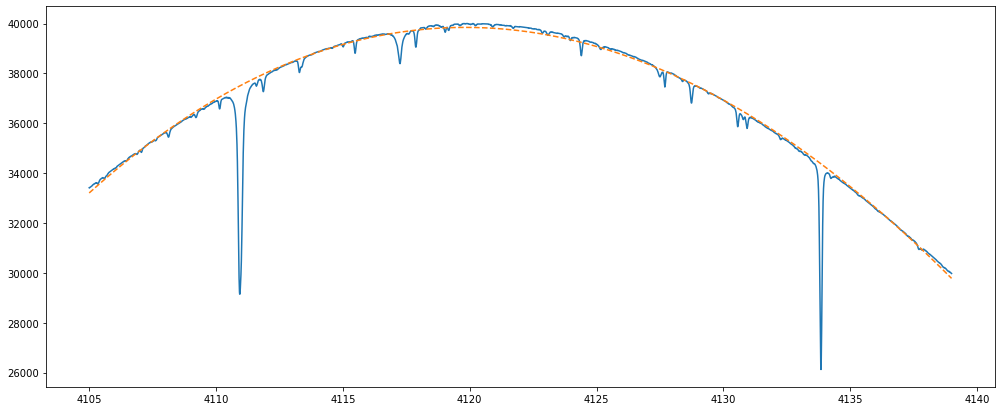

In [195]:
# plot your fit here to check it
plt.plot(wavs, spec)
plt.plot(wavs, cont_fitted_region,'--')
# plt.axvline(4110,c='r')
# plt.axvline(4112,c='r')
# plt.axvline(4133,c='r')
# plt.axvline(4135,c='r')

## Compare with the correct answer

Now you have two fitted continuum, `cont_fitted` and `cont_fitted_region`.\
You are ready to do continuum normalization by dividing the original spectrum, `spec`, with your favorite one.

Compare your normalized spectrum with the correct answer, `norm_spec`, and see how each one does.

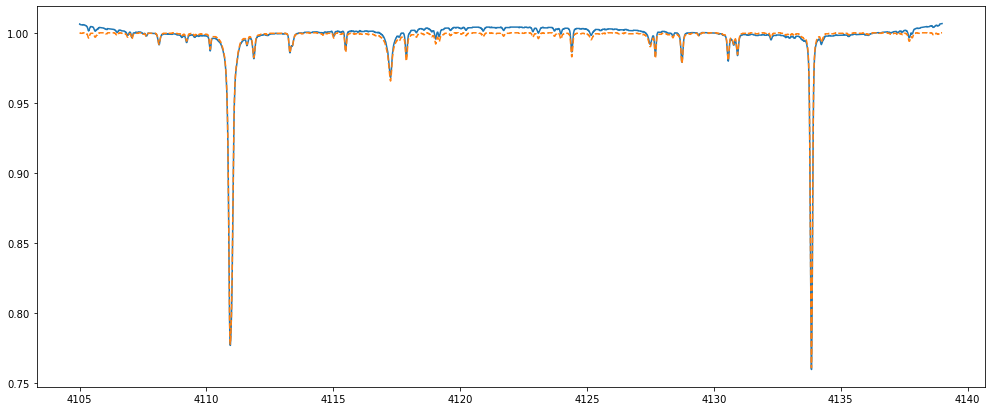

In [198]:
# define your normalized spectrum
my_norm_spec = spec/cont_fitted_region

# plot your favorite normalized spectrum and compare it with the correct answer
plt.plot(wavs, my_norm_spec)  
plt.plot(wavs, norm_spec,'--')

You can tell that your continuum normalization is not perfect. Indeed, continuum normalization is a hard problem to solve computationally. There are many other tricks one could use to do a better job.

Once you have a continuum normalized spectrum, you are ready to calculate line characteristics such as the equivalent width.